<a href="http://colab.research.google.com/github/dipanjanS/nlp_workshop_odsc19/blob/master/Module05%20-%20NLP%20Applications/Project07B%20-%20Text%20Classification%20Deep%20Learning%20CNN%20Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification with CNN

<img src="https://github.com/dipanjanS/nlp_workshop_dhs18/blob/master/Unit%2012%20-%20Project%209%20-%20Sentiment%20Analysis%20-%20Supervised%20Learning/banner.jpeg?raw=1">

In this project, we will attempt at performing text classification for differenciating human and machine generated texts utilizing the power of CNNs.

<img src="https://github.com/dipanjanS/nlp_workshop_dhs18/blob/master/Unit%2012%20-%20Project%209%20-%20Sentiment%20Analysis%20-%20Supervised%20Learning/cnn.png?raw=1">

In [1]:
!pip install contractions
!pip install textsearch
!pip install tqdm
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kamil\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder

In [3]:
dataset = pd.read_csv("Texts_gpt2.csv").dropna()
dataset = dataset.sample(frac=1).reset_index(drop=True)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8151 entries, 0 to 8150
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    8151 non-null   object
 1   label   8151 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 127.5+ KB


In [4]:
# take a peek at the data
dataset.head()

,text,label
0,Ancak birkaç büyük Hollywood stüdyosu önemli k...,1
1,CUMHURİYET Ankara’dan rest İsrail’den özür Cum...,0
2,"Bir kadın seks hayatı gibi hissediyorsa, bir e...",1
3,İran Meclisi Milli Güvenlik ve Dış Politika Ko...,0
4,Bu ikinci çeyrekteki oranın yüzde 5 daha fazla...,0


### Prepare Train Test Split

In [5]:
# build train and test datasets
texts = dataset['text'].values
labels = dataset['label'].values

size = texts.size
train_size = int(size * 0.8)

train_texts = texts[:train_size]
train_labels = labels[:train_size]

test_texts = texts[train_size:]
test_labels = labels[train_size:]

# Text Wrangling & Normalization

In [6]:
import contractions
from bs4 import BeautifulSoup
import numpy as np
import re
import tqdm
import unicodedata

def pre_process_corpus(docs):
    norm_docs = []
    for doc in tqdm.tqdm(docs):
        doc = doc.translate(doc.maketrans("\n\t\r", "   "))
        doc = doc.lower()
        doc = doc.strip()  
        norm_docs.append(doc)
    return norm_docs

In [7]:
%%time

norm_train_reviews = pre_process_corpus(train_texts)
norm_test_reviews = pre_process_corpus(test_texts)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1631/1631 [00:00<00:00, 6211.52it/s]

CPU times: total: 562 ms
Wall time: 1.29 s


## Preprocessing

To prepare text data for our deep learning model, we transform each text into a sequence.
Every word in the text is mapped to an integer index and thus the sentence turns into a sequence of numbers.

To perform this transformation, keras provides the ```Tokenizer```

In [8]:
t = Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents
t.fit_on_texts(train_texts)
t.word_index['<PAD>'] = 0

In [9]:
max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), t.word_index['<UNK>']

(("170'ine", 171354), ('<PAD>', 0), 1)

In [10]:
train_sequences = t.texts_to_sequences(train_texts)

In [11]:
test_sequences = t.texts_to_sequences(test_texts)

In [12]:
print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=171355
Number of Documents=6520


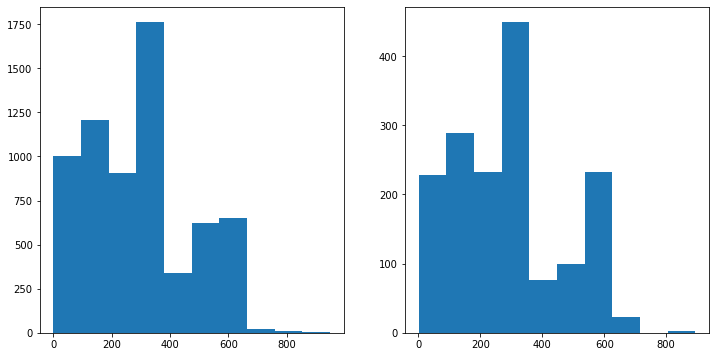

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in train_sequences]
test_lens = [len(s) for s in test_sequences]

fig, ax = plt.subplots(1,2, figsize=(12, 6))
h1 = ax[0].hist(train_lens)
h2 = ax[1].hist(test_lens)

### Sequence Normalization

Not all texts are of same length. To handle this difference in length of texts, we define a maximum length.
For texts which are smaller than this length, we pad them with zeros which longer ones are truncated

In [14]:
MAX_SEQUENCE_LENGTH = 1000

In [15]:
# pad dataset to a maximum review length in words
X_train = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

## Prepare the Model

Since textual data is a sequence of words, we utilize ```1D``` convolutions to scan through the sentences.
The model first transforms each word into lower dimensional embedding/vector space followed by 1d convolutions and then passing the data through dense layers before the final layer for classification

In [16]:
EMBED_SIZE = 300
EPOCHS=2
BATCH_SIZE=128
VOCAB_SIZE = len(t.word_index)

In [17]:
# create the model
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 300)         51406500  
                                                                 
 conv1d (Conv1D)             (None, 1000, 128)         153728    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 500, 128)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 500, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 250, 64)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 250, 32)           8

## Model Training

In [18]:
y_train = train_labels
y_test = test_labels
# Fit the model
model.fit(X_train, y_train, 
          validation_split=0.1,
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          verbose=1)

Epoch 1/2
46/46 [==============================] - 68s 1s/step - loss: 0.3484 - accuracy: 0.8062 - val_loss: 0.0554 - val_accuracy: 0.9969
Epoch 2/2
46/46 [==============================] - 60s 1s/step - loss: 0.0190 - accuracy: 0.9966 - val_loss: 0.0685 - val_accuracy: 0.9969


## Model Evaluation

In [19]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

51/51 [==============================] - 2s 43ms/step - loss: 0.0163 - accuracy: 0.9945
Accuracy: 99.45%


In [20]:
predictions = (model.predict(X_test) > 0.5).astype("int32")

# 1 (human), 0(machine)
predictions = [1 if item == 1 else 0 for item in predictions]

51/51 [==============================] - 2s 42ms/step


In [21]:
from sklearn.metrics import confusion_matrix, classification_report

labels = [0, 1]
print(classification_report(test_labels, predictions))
pd.DataFrame(confusion_matrix(test_labels, predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       802
           1       0.99      1.00      0.99       829

    accuracy                           0.99      1631
   macro avg       0.99      0.99      0.99      1631
weighted avg       0.99      0.99      0.99      1631



,0,1
0,794,8
1,1,828
